# TH2 Poly Europe
This notebook illustrates how to create a histogram with polygonal bins (`TH2Poly`), fill it and draw it. The initial data are stored in `TMultiGraphs` and they represent the surface of some european countries.

The histogram filling is done according to a *Mercator* projection, therefore the bin content should be proportional to the real surface of the countries.

The initial data have been downloaded from http://www.maproom.psu.edu/dcw/. This database was developed in 1991/1992 and national boundaries reflect political reality as of that time.

The program is shooting `npoints` randomly over the Europe area. The number of points inside the countries should be proportional to the country surface. The estimated surface is compared to the surfaces taken from wikipedia.

---

In [2]:
import ROOT

Welcome to JupyROOT 6.07/05


In [3]:
%jsroot on

Variables' initialization:
- Number of points.
- Latitude and longitude.

In [4]:
npoints = 100000

lon1 = -25.
lon2 =  35.
lat1 =  34.
lat2 =  72.
R    = (lat2-lat1)/(lon2-lon1)

Initialize global style.

In [5]:
ROOT.gStyle.SetStatX(0.28)
ROOT.gStyle.SetStatY(0.45)
ROOT.gStyle.SetStatW(0.15)

Create canvas used to draw `TH2Poly` (the map).

In [6]:
W = 800
H = int(R*800)

ce = ROOT.TCanvas("ce","ce",0,0,W,H)
ce.SetGridx()
ce.SetGridy()

Real surfaces taken from Wikipedia.
See http://en.wikipedia.org/wiki/Area_and_population_of_European_countries

In [7]:
countries = [
    "france",     "spain",  "sweden",  "germany",       "finland",
    "norway",     "poland", "italy",   "yugoslavia",    "united_kingdom",
    "romania",    "belarus","greece",  "czechoslovakia","bulgaria",
    "iceland",    "hungary","portugal","austria",       "ireland",
    "lithuania",  "latvia", "estonia", "denmark",       "netherlands",
    "switzerland","moldova","belgium", "albania",       "cyprus",
    "luxembourg", "andorra","malta",   "liechtenstein", "san_marino",
    "monaco"
]
surfaces = [
    547030,     505580,   449964,   357021,     338145,
    324220,     312685,   301230,   255438,     244820,
    237500,     207600,   131940,   127711,     110910,
    103000,     93030,    89242,    83870,      70280,
    65200,      64589,    45226,    43094,      41526,
    41290,      33843,    30528,    28748,      9250,
    2586,       468,      316,      160,        61,
    2
]
nx = len(countries)

Create histogram with surfaces of countries.

In [8]:
h = ROOT.TH1F("h","Countries surfaces (in km^{2})",3,0,3)
for country, surface in zip(countries,surfaces):
    h.Fill(country, surface)
h.LabelsDeflate()

Get remote file.

In [9]:
ROOT.TFile.SetCacheFileDir(".")
fileUrl = "http://root.cern.ch/files/europe.root"
f = ROOT.TFile.Open(fileUrl,"cacheread")
if not f:
    print "Error: Cannot access remote file", fileUrl

Info in <TFile::OpenFromCache>: using local cache copy of http://root.cern.ch/files/europe.root [./files/europe.root]


Create the map and fill it. See the documentation of [TKey](https://root.cern.ch/root/htmldoc/TKey.html) for more information about this loop.

In [10]:
p = ROOT.TH2Poly("Europe","Europe (bin contents are normalized to the surfaces in km^{2})",lon1,lon2,lat1,lat2)
p.GetXaxis().SetNdivisions(520)
p.GetXaxis().SetTitle("longitude")
p.GetYaxis().SetTitle("latitude")
p.SetContour(100)

listOfKeys = ROOT.gDirectory.GetListOfKeys()
for obj in (obj for obj in map(lambda k: k.ReadObj(), listOfKeys) if obj.InheritsFrom("TMultiGraph")):
    p.AddBin(obj)

Do the partitioning of the map.

In [18]:
%%timeit
p.ChangePartition(100,100)

1 loops, best of 3: 2.28 s per loop


Fill `TH2Poly` according to a Mercator projection.

In [12]:
%%timeit
pi    = ROOT.TMath.Pi()
pi4   = pi/4.
alpha = pi/360.

r = ROOT.TRandom3()
fillBenchmarkName = "Filling"

for i in xrange(npoints):
    longitude = r.Uniform(lon1,lon2)
    latitude  = r.Uniform(lat1,lat2)
    x         = longitude
    y         = 38*ROOT.TMath.Log(ROOT.TMath.Tan(pi4+alpha*latitude))
    p.Fill(x,y)
    
nbins = p.GetNumberOfBins()
maximum = p.GetMaximum()

Filling   : Real Time =   3.15 seconds Cpu Time =   3.30 seconds


Fill a histogram with the surfaces computed from `TH2Poly`.

In [13]:
h2 = h.Clone("h2")
h2.Reset()
for j in range(nx):
    for i in range(nbins):
        if countries[j] in p.GetBinName(i+1):
            h2.Fill(countries[j],p.GetBinContent(i+1))
            h2.SetBinError(j, p.GetBinError(i+1))

Normalize the `TH2Poly` bin contents to the real surfaces.

In [14]:
scale = surfaces[0]/maximum
for i in xrange(nbins):
    p.SetBinContent(i+1, scale*p.GetBinContent(i+1))

Draw the canvas with the map.

The canvas contains an object of a type jsROOT cannot currently handle (TH2Poly). Falling back to a static png.


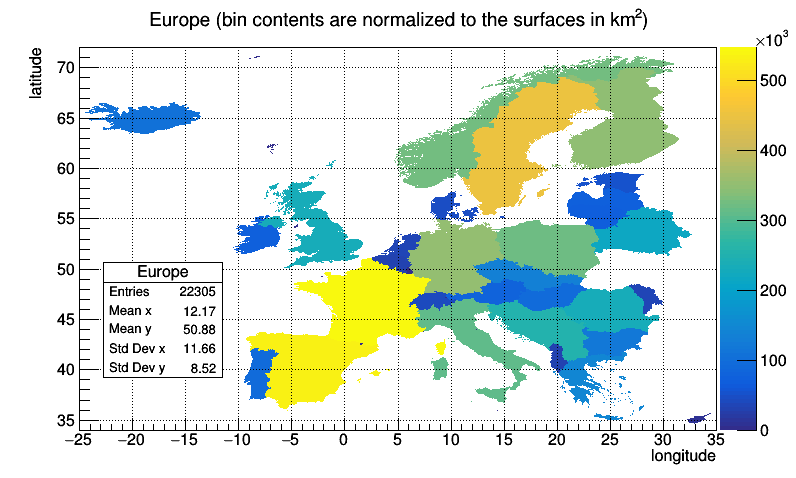

In [15]:
ROOT.gStyle.SetOptStat(1111)

p.Draw("COLZ")
ce.Draw()

Set up another canvas for `h` and `h2` and draw it.

In [16]:
c1 = ROOT.TCanvas("c1", "c1",W+10,0,W-20,H)
c1.SetRightMargin(0.047)

scale = h.GetMaximum()/h2.GetMaximum()

h.SetStats(0)
h.SetLineColor(ROOT.kRed-3)
h.SetLineWidth(2)
h.SetMarkerStyle(20)
h.SetMarkerColor(ROOT.kBlue)
h.SetMarkerSize(0.8)
h.Draw("LP")
h.GetXaxis().SetLabelFont(42)
h.GetXaxis().SetLabelSize(0.03)
h.GetYaxis().SetLabelFont(42)

h2.Scale(scale)
scale2 = ROOT.TMath.Sqrt(scale)
for i in xrange(nx):
    h2.SetBinError(i+1, scale2*h2.GetBinError(i+1))
h2.Draw("E SAME")
h2.SetMarkerStyle(20)
h2.SetMarkerSize(0.8)

leg = ROOT.TLegend(0.5,0.67,0.92,0.8,"","NDC")
leg.SetTextFont(42)
leg.SetTextSize(0.025)
leg.AddEntry(h,"Real countries surfaces from Wikipedia (in km^{2})","lp")
leg.AddEntry(h2,"Countries surfaces from TH2Poly (with errors)","lp")
leg.Draw()

c1.Draw()

Print the surface estimation error.

In [17]:
wikiSum = h.Integral()
polySum = h2.Integral()
error = ROOT.TMath.Abs(wikiSum-polySum)/wikiSum
print "THPoly Europe surface estimation error wrt wikipedia =", 100*error, "% when using", npoints, "points"

THPoly Europe surface estimation error wrt wikipedia = 1.67678431077 % when using 100000 points
